<a href="https://colab.research.google.com/github/FRJackson/hw/blob/main/5245hw4%E7%AE%80%E5%8D%95%E6%AD%A3%E8%B4%9F%E9%9D%A2%E8%AF%84%E4%BB%B7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 尝试导入；若失败再安装（Colab/本地都适用）
try:
    import torch, datasets
except Exception:
    !pip -q install torch datasets tqdm

# 导入常用库
import re
import math
import random
import numpy as np
from collections import Counter

import torch
from torch import nn
from torch.utils.data import DataLoader
from datasets import load_dataset
from tqdm import tqdm

# 设备与随机种子
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 5245
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if device.type == "cuda":
    torch.cuda.manual_seed_all(SEED)
print(f"Using device: {device}")


Using device: cuda


In [ ]:
# 从 Hugging Face Hub 加载 IMDB（包含 'train' 与 'test'）
imdb = load_dataset("imdb")

train_size = len(imdb["train"])
test_size  = len(imdb["test"])  # 按题意：用 test 作为验证
print(f"Train size: {train_size}, Test size (used as validation): {test_size}")

# 看一个训练样本的前200字符与标签
sample = imdb["train"][0]
print("\nSample text:", sample["text"][:200].replace("\n", " "))
print("Label:", sample["label"])   # 1=positive, 0=negative


Train size: 25000, Test size (used as validation): 25000

Sample text: I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ev
Label: 0


In [ ]:
# 简单正则分词：小写化，保留英文单词与缩写（don’t, it’s 等）
TOKEN_PATTERN = re.compile(r"[A-Za-z]+'[A-Za-z]+|[A-Za-z]+")

def tokenize(text: str):
    return [m.group(0).lower() for m in TOKEN_PATTERN.finditer(text)]

# 特殊符号
PAD, UNK = "<pad>", "<unk>"

# 仅用训练集构建词表，避免信息泄露
min_freq = 2          # 你可调整（超参数）
max_vocab_size = None # 可选；如需上限（例如 100_000）可设定

counter = Counter()
for ex in tqdm(imdb["train"], desc="Building vocab (counting)"):
    counter.update(tokenize(ex["text"]))

# 过滤低频，并可选择截断至最大词表大小
words = [w for w, c in counter.items() if c >= min_freq]
if max_vocab_size is not None:
    words = words[:max_vocab_size - 2]  # -2 给 PAD/UNK 腾位置

itos = [PAD, UNK] + words
stoi = {w: i for i, w in enumerate(itos)}

vocab_size = len(itos)
pad_idx = stoi[PAD]
unk_idx = stoi[UNK]

print(f"Vocab size: {vocab_size} (min_freq={min_freq})  PAD={pad_idx}, UNK={unk_idx}")
print("Tokenize demo:", tokenize("It was not bad at all."))


Building vocab (counting): 100%|██████████| 25000/25000 [00:04<00:00, 5026.19it/s]

Vocab size: 49319 (min_freq=2)  PAD=0, UNK=1
Tokenize demo: ['it', 'was', 'not', 'bad', 'at', 'all']


In [ ]:
# 简单正则分词：小写化，保留英文单词与缩写（don’t, it’s 等）
TOKEN_PATTERN = re.compile(r"[A-Za-z]+'[A-Za-z]+|[A-Za-z]+")

def tokenize(text: str):
    return [m.group(0).lower() for m in TOKEN_PATTERN.finditer(text)]

# 特殊符号
PAD, UNK = "<pad>", "<unk>"

# 仅用训练集构建词表，避免信息泄露
min_freq = 2          # 你可调整（超参数）
max_vocab_size = None # 可选；如需上限（例如 100_000）可设定

counter = Counter()
for ex in tqdm(imdb["train"], desc="Building vocab (counting)"):
    counter.update(tokenize(ex["text"]))

# 过滤低频，并可选择截断至最大词表大小
words = [w for w, c in counter.items() if c >= min_freq]
if max_vocab_size is not None:
    words = words[:max_vocab_size - 2]  # -2 给 PAD/UNK 腾位置

itos = [PAD, UNK] + words
stoi = {w: i for i, w in enumerate(itos)}

vocab_size = len(itos)
pad_idx = stoi[PAD]
unk_idx = stoi[UNK]

print(f"Vocab size: {vocab_size} (min_freq={min_freq})  PAD={pad_idx}, UNK={unk_idx}")
print("Tokenize demo:", tokenize("It was not bad at all."))


Building vocab (counting): 100%|██████████| 25000/25000 [00:05<00:00, 4996.27it/s]


Vocab size: 49319 (min_freq=2)  PAD=0, UNK=1
Tokenize demo: ['it', 'was', 'not', 'bad', 'at', 'all']


In [ ]:
# 文本→ID 序列；加入 max_tokens 截断以控时（可调）
max_tokens = 400  # 超参数：最大序列长度；可调大/小以平衡速度与效果

def text_to_ids(text: str):
    ids = [stoi.get(tok, unk_idx) for tok in tokenize(text)]
    if max_tokens is not None and len(ids) > max_tokens:
        ids = ids[:max_tokens]
    return ids

# collate：按批次最大长度动态 pad，并返回长度张量
def collate_batch(examples):
    seqs = [text_to_ids(ex["text"]) for ex in examples]
    labels = [ex["label"] for ex in examples]  # 原始即 0/1

    max_len = max((len(s) for s in seqs), default=0)
    padded, lengths = [], []
    for s in seqs:
        lengths.append(len(s))
        if len(s) < max_len:
            s = s + [pad_idx] * (max_len - len(s))
        padded.append(s)

    x = torch.tensor(padded, dtype=torch.long, device=device)       # [B, T]
    lens = torch.tensor(lengths, dtype=torch.long, device=device)   # [B]
    y = torch.tensor(labels, dtype=torch.float32, device=device)    # [B]（BCE需要float）
    return x, lens, y

batch_size = 64  # 超参数：批大小
train_loader = DataLoader(
    imdb["train"], batch_size=batch_size, shuffle=True,
    collate_fn=collate_batch, drop_last=False
)
val_loader = DataLoader(
    imdb["test"], batch_size=batch_size, shuffle=False,
    collate_fn=collate_batch, drop_last=False
)

# 试取一批，检查形状
xb, lb, yb = next(iter(train_loader))
print("One batch shapes:", xb.shape, lb.shape, yb.shape)  # [B,T], [B], [B]


One batch shapes: torch.Size([64, 400]) torch.Size([64]) torch.Size([64])


In [ ]:
# 文本→ID 序列；加入 max_tokens 截断以控时（可调）
max_tokens = 400  # 超参数：最大序列长度；可调大/小以平衡速度与效果

def text_to_ids(text: str):
    ids = [stoi.get(tok, unk_idx) for tok in tokenize(text)]
    if max_tokens is not None and len(ids) > max_tokens:
        ids = ids[:max_tokens]
    return ids

# collate：按批次最大长度动态 pad，并返回长度张量
def collate_batch(examples):
    seqs = [text_to_ids(ex["text"]) for ex in examples]
    labels = [ex["label"] for ex in examples]  # 原始即 0/1

    max_len = max((len(s) for s in seqs), default=0)
    padded, lengths = [], []
    for s in seqs:
        lengths.append(len(s))
        if len(s) < max_len:
            s = s + [pad_idx] * (max_len - len(s))
        padded.append(s)

    x = torch.tensor(padded, dtype=torch.long, device=device)       # [B, T]
    lens = torch.tensor(lengths, dtype=torch.long, device=device)   # [B]
    y = torch.tensor(labels, dtype=torch.float32, device=device)    # [B]（BCE需要float）
    return x, lens, y

batch_size = 64  # 超参数：批大小
train_loader = DataLoader(
    imdb["train"], batch_size=batch_size, shuffle=True,
    collate_fn=collate_batch, drop_last=False
)
val_loader = DataLoader(
    imdb["test"], batch_size=batch_size, shuffle=False,
    collate_fn=collate_batch, drop_last=False
)

# 试取一批，检查形状
xb, lb, yb = next(iter(train_loader))
print("One batch shapes:", xb.shape, lb.shape, yb.shape)  # [B,T], [B], [B]


One batch shapes: torch.Size([64, 400]) torch.Size([64]) torch.Size([64])


In [ ]:
class SentimentBiLSTM(nn.Module):
    def __init__(self, vocab_size, emb_dim=100, hidden_dim=128, num_layers=1,
                 bidirectional=True, dropout=0.3, pad_idx=0):
        super().__init__()
        # 自建可训练 embedding（随机初始化）
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=pad_idx)

        # 双向 LSTM 编码器
        self.lstm = nn.LSTM(
            input_size=emb_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional
        )

        # Dropout 正则
        self.dropout = nn.Dropout(dropout)

        # 双向 → 输出维度翻倍
        lstm_out_dim = hidden_dim * (2 if bidirectional else 1)

        # 二分类的线性层（输出 logits）
        self.fc = nn.Linear(lstm_out_dim, 1)

    def forward(self, x, lengths):
        # x: [B, T]；lengths: [B]
        emb = self.embedding(x)  # [B, T, E]

        # pack 提升效率（需按长度）
        packed = nn.utils.rnn.pack_padded_sequence(
            emb, lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        packed_out, (h_n, c_n) = self.lstm(packed)

        # h_n 形状：[num_layers * num_directions, B, H]
        if self.lstm.bidirectional:
            # 取最后一层的正/反向 hidden 并拼接
            h_fwd = h_n[-2, :, :]  # [B, H]
            h_bwd = h_n[-1, :, :]  # [B, H]
            feat = torch.cat([h_fwd, h_bwd], dim=1)  # [B, 2H]
        else:
            feat = h_n[-1, :, :]  # [B, H]

        feat = self.dropout(feat)
        logits = self.fc(feat).squeeze(1)  # [B]
        return logits  # 原始分数（后接 BCEWithLogitsLoss）


In [ ]:
# 关键超参数（可调）
emb_dim = 100
hidden_dim = 128
num_layers = 1
bidirectional = True
dropout = 0.3
lr = 1e-3
max_epochs = 40     # (d) 最多 40
patience = 3        # 早停耐心
clip_grad = 1.0     # 梯度裁剪阈值（防爆炸），可设 None 关闭

# 实例化模型
model = SentimentBiLSTM(
    vocab_size=vocab_size,
    emb_dim=emb_dim,
    hidden_dim=hidden_dim,
    num_layers=num_layers,
    bidirectional=bidirectional,
    dropout=dropout,
    pad_idx=pad_idx
).to(device)

# 损失函数与优化器
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# 计算 batch 准确率
@torch.no_grad()
def binary_accuracy_from_logits(logits, y):
    preds = (torch.sigmoid(logits) >= 0.5).float()
    return (preds == y).float().mean().item()


In [ ]:
best_val_loss = float("inf")
best_state = None
epochs_no_improve = 0

train_history = []
val_history = []

for epoch in range(1, max_epochs + 1):
    # ===== Train =====
    model.train()
    total_loss, total_acc, n = 0.0, 0.0, 0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{max_epochs} [train]")
    for xb, lens, yb in pbar:
        optimizer.zero_grad()
        logits = model(xb, lens)
        loss = criterion(logits, yb)
        loss.backward()

        # 可选：梯度裁剪
        if clip_grad is not None:
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip_grad)

        optimizer.step()

        # 统计
        bsz = yb.size(0)
        with torch.no_grad():
            acc = binary_accuracy_from_logits(logits, yb)
        total_loss += loss.item() * bsz
        total_acc  += acc * bsz
        n += bsz
        pbar.set_postfix(loss=total_loss/n, acc=total_acc/n)

    train_loss = total_loss / n
    train_acc  = total_acc / n
    train_history.append((train_loss, train_acc))

    # ===== Validate (使用 test 作为验证集，符合题目要求) =====
    model.eval()
    v_total_loss, v_total_acc, vn = 0.0, 0.0, 0
    with torch.no_grad():
        for xb, lens, yb in tqdm(val_loader, desc=f"Epoch {epoch}/{max_epochs} [val]"):
            logits = model(xb, lens)
            loss = criterion(logits, yb)
            bsz = yb.size(0)
            acc = binary_accuracy_from_logits(logits, yb)

            v_total_loss += loss.item() * bsz
            v_total_acc  += acc * bsz
            vn += bsz

    val_loss = v_total_loss / vn
    val_acc  = v_total_acc / vn
    val_history.append((val_loss, val_acc))

    print(f"Epoch {epoch:02d}: "
          f"train_loss={train_loss:.4f}, train_acc={train_acc:.4f} | "
          f"val_loss={val_loss:.4f}, val_acc={val_acc:.4f}")

    # 早停
    if val_loss < best_val_loss - 1e-4:
        best_val_loss = val_loss
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch} (patience={patience})")
            break

# 恢复最佳模型参数
if best_state is not None:
    model.load_state_dict(best_state)
    model.to(device)


Epoch 1/40 [val]: 100%|██████████| 391/391 [00:09<00:00, 43.25it/s]


Epoch 01: train_loss=0.6020, train_acc=0.6708 | val_loss=0.5164, val_acc=0.7555


Epoch 2/40 [val]: 100%|██████████| 391/391 [00:08<00:00, 43.66it/s]


Epoch 02: train_loss=0.4360, train_acc=0.8035 | val_loss=0.4220, val_acc=0.8102


Epoch 3/40 [val]: 100%|██████████| 391/391 [00:08<00:00, 43.49it/s]


Epoch 03: train_loss=0.3215, train_acc=0.8661 | val_loss=0.4098, val_acc=0.8293


Epoch 4/40 [val]: 100%|██████████| 391/391 [00:09<00:00, 43.16it/s]


Epoch 04: train_loss=0.2319, train_acc=0.9084 | val_loss=0.3871, val_acc=0.8315


Epoch 5/40 [val]: 100%|██████████| 391/391 [00:09<00:00, 43.04it/s]


Epoch 05: train_loss=0.1724, train_acc=0.9354 | val_loss=0.3972, val_acc=0.8575


Epoch 6/40 [val]: 100%|██████████| 391/391 [00:09<00:00, 42.94it/s]


Epoch 06: train_loss=0.1180, train_acc=0.9576 | val_loss=0.4903, val_acc=0.8457


Epoch 7/40 [val]: 100%|██████████| 391/391 [00:09<00:00, 42.80it/s]

Epoch 07: train_loss=0.0725, train_acc=0.9756 | val_loss=0.4926, val_acc=0.8552
Early stopping at epoch 7 (patience=3)


In [ ]:
model.eval()
v_total_loss, v_total_acc, vn = 0.0, 0.0, 0
with torch.no_grad():
    for xb, lens, yb in tqdm(val_loader, desc="Final eval [val=test]"):
        logits = model(xb, lens)
        loss = criterion(logits, yb)
        bsz = yb.size(0)
        acc = binary_accuracy_from_logits(logits, yb)

        v_total_loss += loss.item() * bsz
        v_total_acc  += acc * bsz
        vn += bsz

final_val_loss = v_total_loss / vn
final_val_acc  = v_total_acc / vn
print(f"[Final] val_loss={final_val_loss:.4f}, val_acc={final_val_acc:.4f}")


Final eval [val=test]: 100%|██████████| 391/391 [00:09<00:00, 42.76it/s]

[Final] val_loss=0.3871, val_acc=0.8315


In [ ]:
@torch.no_grad()
def predict_proba(text: str) -> float:
    """返回“正向情感”的概率 P(pos)"""
    model.eval()
    ids = text_to_ids(text)
    x = torch.tensor([ids], dtype=torch.long, device=device)
    l = torch.tensor([len(ids)], dtype=torch.long, device=device)
    logits = model(x, l)  # [1]
    return torch.sigmoid(logits)[0].item()

def classify(text: str):
    p = predict_proba(text)
    label = "positive" if p >= 0.5 else "negative"
    return label, p

sentences = [
    "You must watch this film. It was incredibly funny.",
    "It was not bad at all.",
    "This movie was neither that funny nor witty."
]

for s in sentences:
    lab, p = classify(s)
    print(f"TEXT: {s}\nP(pos)={p:.4f}  →  Pred={lab}\n")


TEXT: You must watch this film. It was incredibly funny.
P(pos)=0.5766  →  Pred=positive

TEXT: It was not bad at all.
P(pos)=0.0400  →  Pred=negative

TEXT: This movie was neither that funny nor witty.
P(pos)=0.4663  →  Pred=negative



In [ ]:
# 你可修改这条影评试试不同表达
my_review = "The plot was slow, but the performances were heartfelt and the ending felt uplifting."
lab, p = classify(my_review)
print(f"My review: {my_review}\nP(pos)={p:.4f} → Pred={lab}\n")

# 供作业报告使用的简要局限总结（可直接粘贴）
limitations = r"""
Model limitations（模型局限）:
1) Negation handling（否定处理）:
   短语如 "not bad"、"neither ... nor ..." 属于复杂否定，简单序列模型较难精准捕捉。
2) Long-distance dependencies（长距离依赖）:
   LSTM能缓解但对超长文本仍可能稀释关键信号；我们采用了 max_tokens 截断以控时。
3) Vocabulary & OOV（词表与未登录词）:
   仅用训练集构词表并设置 min_freq，低频词会映射为 <unk>，信息损失在所难免。
4) No pretraining（无预训练）:
   完全从零训练的 embedding 相比预训练模型（如 BERT/RoBERTa）通常性能略逊。
5) Validation protocol（验证策略）:
   按题意用 test 作为训练过程中的“验证”以监控早停；严格评测理应保留独立 dev 集。
"""
print(limitations)


My review: The plot was slow, but the performances were heartfelt and the ending felt uplifting.
P(pos)=0.4653 → Pred=negative


Model limitations（模型局限）:
1) Negation handling（否定处理）:
   短语如 "not bad"、"neither ... nor ..." 属于复杂否定，简单序列模型较难精准捕捉。
2) Long-distance dependencies（长距离依赖）:
   LSTM能缓解但对超长文本仍可能稀释关键信号；我们采用了 max_tokens 截断以控时。
3) Vocabulary & OOV（词表与未登录词）:
   仅用训练集构词表并设置 min_freq，低频词会映射为 <unk>，信息损失在所难免。
4) No pretraining（无预训练）:
   完全从零训练的 embedding 相比预训练模型（如 BERT/RoBERTa）通常性能略逊。
5) Validation protocol（验证策略）:
   按题意用 test 作为训练过程中的“验证”以监控早停；严格评测理应保留独立 dev 集。



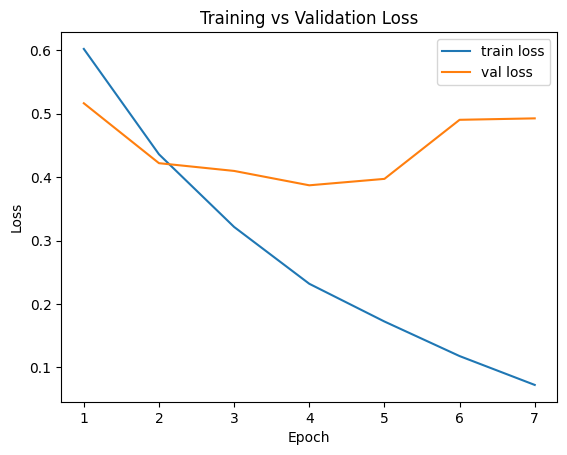

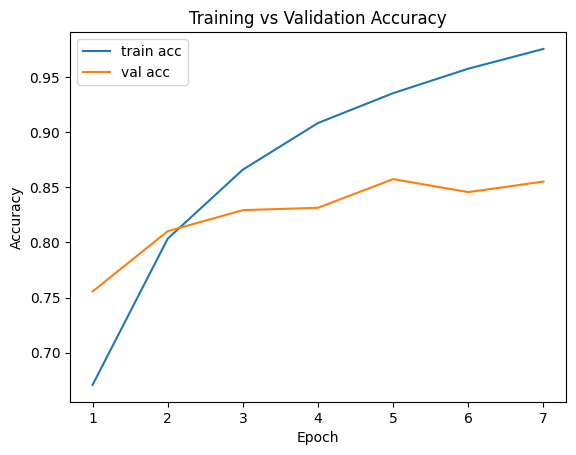

In [ ]:
# 可视化训练过程（要求：matplotlib，不用 seaborn；一图一个指标；不指定颜色）
import matplotlib.pyplot as plt

# 拆分历史记录
train_losses = [x[0] for x in train_history]
train_accs   = [x[1] for x in train_history]
val_losses   = [x[0] for x in val_history]
val_accs     = [x[1] for x in val_history]
epochs = list(range(1, len(train_history) + 1))

# 图1：Loss
plt.figure()
plt.plot(epochs, train_losses, label="train loss")
plt.plot(epochs, val_losses, label="val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()

# 图2：Accuracy
plt.figure()
plt.plot(epochs, train_accs, label="train acc")
plt.plot(epochs, val_accs, label="val acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.show()


In [ ]:
import torch
from torch import nn

class SentimentBiLSTMWithPooling(nn.Module):
    def __init__(self, vocab_size, emb_dim=100, hidden_dim=128, num_layers=1,
                 bidirectional=True, dropout=0.3, pad_idx=0):
        super().__init__()
        # 1) 自建可训练 embedding
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=pad_idx)

        # 2) 双向 LSTM
        self.lstm = nn.LSTM(
            input_size=emb_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional
        )

        # 3) Dropout 正则
        self.dropout = nn.Dropout(dropout)

        # 4) 由于做 mean+max 池化并拼接，维度 = (方向数 * hidden_dim) * 2
        lstm_feat_dim = hidden_dim * (2 if bidirectional else 1)
        pooled_dim = lstm_feat_dim * 2  # mean + max

        # 5) 线性分类层
        self.fc = nn.Linear(pooled_dim, 1)

        # 6) 记录 pad idx 以做 mask
        self.pad_idx = pad_idx

    def forward(self, x, lengths):
        # x: [B, T]；lengths: [B]
        emb = self.embedding(x)  # [B, T, E]

        # LSTM：先 pack 提升效率
        packed = nn.utils.rnn.pack_padded_sequence(
            emb, lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        packed_out, _ = self.lstm(packed)

        # 解包回 [B, T, H*dir]
        out, out_lengths = nn.utils.rnn.pad_packed_sequence(packed_out, batch_first=True)  # [B, T, D]
        # 注：out_lengths 应与 lengths 一致

        # 基于长度构造 mask，True 表示有效 token
        # mask: [B, T, 1]
        max_T = out.size(1)
        range_row = torch.arange(max_T, device=out.device).unsqueeze(0)  # [1, T]
        valid = (range_row < lengths.unsqueeze(1)).unsqueeze(2)          # [B, T, 1]

        # 置无效位置为极小值（用于 max）或 0（用于 sum/mean）
        out_masked_for_max = out.masked_fill(~valid, -1e9)   # 无效处→巨大负数，max时忽略
        out_masked_for_sum = out.masked_fill(~valid, 0.0)    # 无效处→0，便于求和

        # max pooling / mean pooling
        max_pool, _ = out_masked_for_max.max(dim=1)          # [B, D]
        sum_pool = out_masked_for_sum.sum(dim=1)             # [B, D]
        lens_f = lengths.clamp(min=1).unsqueeze(1).float()   # [B, 1]
        mean_pool = sum_pool / lens_f                        # [B, D]

        # 拼接 mean 与 max
        feat = torch.cat([mean_pool, max_pool], dim=1)       # [B, 2D]
        feat = self.dropout(feat)
        logits = self.fc(feat).squeeze(1)                    # [B]
        return logits


In [ ]:
def train_eval_one_model(model, train_loader, val_loader, max_epochs=40, lr=1e-3,
                         patience=3, clip_grad=1.0, device=None):
    device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    best_val_loss = float("inf")
    best_state = None
    epochs_no_improve = 0
    train_hist, val_hist = [], []

    for epoch in range(1, max_epochs + 1):
        # Train
        model.train()
        tot_loss, tot_acc, n = 0.0, 0.0, 0
        for xb, lens, yb in DataLoader(train_loader.dataset, batch_size=train_loader.batch_size,
                                       shuffle=True, collate_fn=train_loader.collate_fn):
            optimizer.zero_grad()
            logits = model(xb, lens)
            loss = criterion(logits, yb)
            loss.backward()
            if clip_grad is not None:
                nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip_grad)
            optimizer.step()
            bsz = yb.size(0)
            with torch.no_grad():
                acc = binary_accuracy_from_logits(logits, yb)
            tot_loss += loss.item() * bsz
            tot_acc  += acc * bsz
            n += bsz
        train_loss, train_acc = tot_loss / n, tot_acc / n
        train_hist.append((train_loss, train_acc))

        # Val
        model.eval()
        v_loss, v_acc, m = 0.0, 0.0, 0
        with torch.no_grad():
            for xb, lens, yb in DataLoader(val_loader.dataset, batch_size=val_loader.batch_size,
                                           shuffle=False, collate_fn=val_loader.collate_fn):
                logits = model(xb, lens)
                loss = criterion(logits, yb)
                bsz = yb.size(0)
                acc = binary_accuracy_from_logits(logits, yb)
                v_loss += loss.item() * bsz
                v_acc  += acc * bsz
                m += bsz
        val_loss, val_acc = v_loss / m, v_acc / m
        val_hist.append((val_loss, val_acc))

        print(f"Epoch {epoch:02d} | train_loss={train_loss:.4f}, train_acc={train_acc:.4f} "
              f"| val_loss={val_loss:.4f}, val_acc={val_acc:.4f}")

        if val_loss < best_val_loss - 1e-4:
            best_val_loss = val_loss
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch} (patience={patience})")
                break

    if best_state is not None:
        model.load_state_dict(best_state)
        model.to(device)

    return model, train_hist, val_hist, best_val_loss, val_hist[-1][1]

# 示例（按需运行，训练耗时取决于设备）：
# 1) baseline（末层 hidden 拼接）
model1 = SentimentBiLSTM(vocab_size, emb_dim, hidden_dim, num_layers,
                         bidirectional, dropout, pad_idx)
model1, tr1, va1, best_loss1, best_acc1 = train_eval_one_model(
    model1, train_loader, val_loader, max_epochs=max_epochs, lr=lr,
    patience=patience, clip_grad=clip_grad, device=device
)

# 2) pooling 变体（Mean+Max）
# model2 = SentimentBiLSTMWithPooling(vocab_size, emb_dim, hidden_dim, num_layers,
#                                     bidirectional, dropout, pad_idx)
# model2, tr2, va2, best_loss2, best_acc2 = train_eval_one_model(
#     model2, train_loader, val_loader, max_epochs=max_epochs, lr=lr,
#     patience=patience, clip_grad=clip_grad, device=device
# )

# 你可以把 tr1/va1 与 tr2/va2 拿去画曲线对比


Epoch 01 | train_loss=0.5965, train_acc=0.6711 | val_loss=0.5191, val_acc=0.7463
Epoch 02 | train_loss=0.4209, train_acc=0.8107 | val_loss=0.4223, val_acc=0.8088
Epoch 03 | train_loss=0.3156, train_acc=0.8667 | val_loss=0.3707, val_acc=0.8362
Epoch 04 | train_loss=0.2394, train_acc=0.9038 | val_loss=0.3773, val_acc=0.8445
Epoch 05 | train_loss=0.1805, train_acc=0.9298 | val_loss=0.3873, val_acc=0.8592
Epoch 06 | train_loss=0.1268, train_acc=0.9546 | val_loss=0.4348, val_acc=0.8566
Early stopping at epoch 6 (patience=3)
